Mateusz Boguszewski 82613
# LABORATORIUM 9

Ten kod jest implementacją algorytmu renderowania trójwymiarowych kul za pomocą CUDA (arkusz języka programowania GPU firmy NVIDIA). Algorytm ten tworzy obraz o rozmiarze 10000x10000 pixeli, a każdy pixel jest kolorem kuli, z którą promień światła padający z kamery wirtualnej jest najlepiej skorelowany (tzn. najbliższy). W celu zwiększenia realizmu, każda kula ma swój własny kolor, promień i położenie w przestrzeni trójwymiarowej.

Kod składa się z definicji struktury "Sphere" reprezentującej kulę oraz funkcji kernel, która jest uruchamiana na GPU i oblicza kolor dla każdego pixela. W funkcji main, tworzone są losowe kule, a następnie przesyłane są do pamięci GPU. Następnie uruchamiana jest funkcja kernel na GPU, która oblicza kolor dla każdego pixela i zapisuje go w tablicy "dev_bitmap". Po zakończeniu obliczeń, obraz jest zapisywany do pliku "RayGpu.ppm".

Kod zawiera również kilka dodatkowych funkcji i zmiennych. Funkcja "rnd" jest funkcją pomocniczą, która zwraca losową liczbę z zadanego zakresu. Zmienna "INF" jest stałą reprezentującą nieskończoność i jest używana w funkcji "hit" struktury "Sphere" do oznaczenia, że promień światła nie został trafiony przez kulę. Funkcja "save_to_file" jest używana do zapisania obrazu do pliku "RayGpu.ppm".

Główną częścią kodu jest funkcja kernel, która jest uruchamiana na GPU. Funkcja ta przyjmuje jako argumenty tablicę struktur "Sphere" oraz tablicę "ptr", do której zapisywane są wyniki obliczeń. Każdy wątek GPU oblicza kolor dla jednego pixela obrazu, przy użyciu pętli przechodzącej przez wszystkie kule i obliczającej, która z nich jest najlepszym kandydatem do została wyświetlona dla danego pixela. Po obliczeniu koloru, jest on zapisywany w tablicy "ptr". Po zakończeniu obliczeń dla wszystkich pixeli, obraz jest zapisywany do pliku "RayGpu.ppm".

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-9jm1csfa
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-9jm1csfa
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [ ]:
 %load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [ ]:
%%cu
#include <stdio.h>
#define DIM 5000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


__global__ void kernel( Sphere *s, unsigned char *ptr ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayGpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {
  cudaEvent_t start, stop;
  cudaEventCreate( &start );
  cudaEventCreate( &stop);
  
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM* DIM*4;
  unsigned char *dev_bitmap;

  cudaMalloc((void**)&dev_bitmap, image_size); 
  data.dev_bitmap=dev_bitmap;
  Sphere *s;


cudaMalloc((void**)&s, sizeof(Sphere)* SPHERES );


Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );

for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
     cudaMemcpy( s, temp_s, sizeof(Sphere)* SPHERES, cudaMemcpyHostToDevice);
     free( temp_s);
}

dim3 block(16, 16);
dim3 grid((DIM + block.x - 1) / block.x, (DIM + block.y - 1) / block.y);

cudaEventRecord( start, 0);

kernel<<<grid, block>>>(s, dev_bitmap);

cudaEventRecord( stop, 0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime, start, stop);
printf("Time: %f s\n", elapsedTime / 1000);

cudaMemcpy( bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
save_to_file(bitmap);
}



Time: 0.031361 ms



Ten kod jest implementacją algorytmu renderowania trójwymiarowych kul na CPU (procesorze). Algorytm ten działa podobnie do poprzedniego kodu, ale zamiast korzystać z GPU do obliczeń, używa procesora.

Kod składa się z definicji struktury "Sphere" reprezentującej kulę oraz funkcji "compute_on_cpu", która oblicza kolor dla pojedynczego pixela na CPU. W funkcji main, tworzone są losowe kule, a następnie obliczane są kolory dla każdego pixela za pomocą pętli przechodzącej przez wszystkie piksele i wywołującej funkcję "compute_on_cpu" dla każdego z nich. Po obliczeniu kolorów dla wszystkich pixeli, obraz jest zapisywany do pliku "RayCpu.ppm".

Kod zawiera również kilka dodatkowych funkcji i zmiennych. Funkcja "rnd" jest funkcją pomocniczą, która zwraca losową liczbę z zadanego zakresu. Zmienna "INF" jest stałą reprezentującą nieskończoność i jest używana w funkcji "hit" struktury "Sphere" do oznaczenia, że promień światła nie został trafiony przez kulę. Funkcja "save_to_file" jest używana do zapisania obrazu do pliku "RayCpu.ppm".

Główną częścią kodu jest funkcja "compute_on_cpu", która oblicza kolor dla pojedynczego pixela na CPU. Funkcja ta przyjmuje jako argumenty tablicę struktur "Sphere", współrzędne pixela "x" i "y" oraz tablicę "ptr", do której zapisywane są wyniki obliczeń. Funkcja ta działa podobnie do funkcji kernel z poprzedniego kodu, ale jest uruchamiana tylko dla pojedynczego pixela. Po obliczeniu koloru, jest on zapisywany w tablicy "ptr". Po obliczeniu kolorów dla wszystkich pixeli, obraz jest zapisywany do pliku "RayCpu.ppm". Kod zawiera również mierzenie

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-z9apoxst
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-z9apoxst
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=60ef9a11987076690e13944f54a4aa9bcaf77d17259522a64e728c30e16a15f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-opmt76t7/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
 %load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [ ]:
%%cu
#include <stdio.h>
#define DIM 5000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


void compute_on_cpu(Sphere *s, int x, int y, unsigned char *ptr) {
 
    int offset = x + y * DIM;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};


void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayCpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {
    clock_t start, end;
    double execution_time;
    start = clock();
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM*DIM*4;
  Sphere *s;
  Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
  s = temp_s;

for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
}

for (int y=0; y<DIM; y++) {
    for (int x=0; x<DIM; x++) {
        compute_on_cpu(s, x, y, bitmap);
    }
}


    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
    save_to_file(bitmap);
}



Time taken to execute in seconds : 0.731769


Porównanie czasu pracy tych dwóch kodów w zależności na jakiej części komputera on pracuje:

**WARTOŚCI GPU:**

DIM: 1000
time: 0.000363 s

DIM: 2000
time: 0.001286 s

DIM: 5000
time: 0.007891 s


**WARTOŚCI CPU:**

DIM: 1000 
time: 0.199786 s

DIM: 2000
time: 0.814849 s

DIM: 5000 
time: 5.053354 s



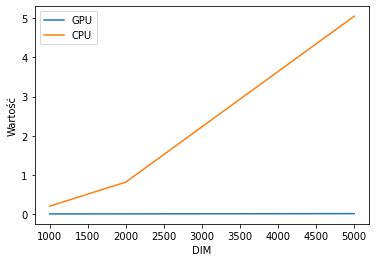

In [1]:
import matplotlib.pyplot as plt

# wartości DIM
dim_values = [1000, 2000, 5000]

# wartości dla GPU
gpu_values = [0.000363, 0.001286, 0.007891]

# wartości dla CPU
cpu_values = [0.199786, 0.814849, 5.053354]

# rysowanie wykresu liniowego z wartościami DIM jako oś x i wartościami GPU i CPU jako oś y
plt.plot(dim_values, gpu_values, label="GPU")
plt.plot(dim_values, cpu_values, label="CPU")

# dodanie etykiet dla osi x i y
plt.xlabel("DIM")
plt.ylabel("Wartość")

# dodanie legendy
plt.legend()

# wyświetlenie wykresu
plt.show()

GPU ma w tym przypadku linie praktycznie rownolegle do osi x czyli jest bardzo szybki a CPU jak widac czas wykonania rosnie dosyc szybko.